In [38]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from raw_processing import ColumnTransformerPandas
from sklearn import set_config

from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier

from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import StandardScaler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import ADASYN
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, RandomizedSearchCV, validation_curve
from sklearn.metrics import balanced_accuracy_score, precision_score, recall_score, f1_score, make_scorer, roc_auc_score

from performance import plot_roc, plot_feature_importance

### Generate dataset

In [26]:
label_scheme = 'labels_2'

pd.options.display.max_columns = None

dataset = pd.read_csv(f'../processed_data/dataset_allfeatures_inc_labels.csv', low_memory=False)
dataset = dataset[dataset[label_scheme].notna()].reset_index(drop=True)
print(dataset[label_scheme].value_counts())
dataset.head()

dwarf_nova_SU_UMa    630
dwarf_nova_Z_Cam     174
nova_like            144
nova_like_VY_Scl     120
dwarf_nova_U_Gem     116
polar                114
int_polar             49
AMCVn                 46
nova                  46
Name: labels_2, dtype: int64


,oid_ztf,oid_aavso,type_aavso,Eclipsing,CV_Types,CV_subtypes,CV_subsubtypes,eclipse_clear,manual_label,Clarity,labels_1,labels_2,labels_3,labels_4,Amplitude_g,AndersonDarling_g,Autocor_length_g,Beyond1Std_g,CAR_mean_g,CAR_sigma_g,CAR_tau_g,Con_g,Eta_e_g,FluxPercentileRatioMid20_g,FluxPercentileRatioMid35_g,FluxPercentileRatioMid50_g,FluxPercentileRatioMid65_g,FluxPercentileRatioMid80_g,Freq1_harmonics_amplitude_0_g,Freq1_harmonics_amplitude_1_g,Freq1_harmonics_amplitude_2_g,Freq1_harmonics_amplitude_3_g,Freq1_harmonics_rel_phase_1_g,Freq1_harmonics_rel_phase_2_g,Freq1_harmonics_rel_phase_3_g,Freq2_harmonics_amplitude_0_g,Freq2_harmonics_amplitude_1_g,Freq2_harmonics_amplitude_2_g,Freq2_harmonics_amplitude_3_g,Freq2_harmonics_rel_phase_1_g,Freq2_harmonics_rel_phase_2_g,Freq2_harmonics_rel_phase_3_g,Freq3_harmonics_amplitude_0_g,Freq3_harmonics_amplitude_1_g,Freq3_harmonics_amplitude_2_g,Freq3_harmonics_amplitude_3_g,Freq3_harmonics_rel_phase_1_g,Freq3_harmonics_rel_phase_2_g,Freq3_harmonics_rel_phase_3_g,Gskew_g,LinearTrend_g,MaxSlope_g,Mean_g,Meanvariance_g,MedianAbsDev_g,MedianBRP_g,PairSlopeTrend_g,PercentAmplitude_g,PercentDifferenceFluxPercentile_g,PeriodLS_g,Period_fit_g,Psi_CS_g,Psi_eta_g,Q31_g,Rcs_g,Skew_g,SlottedA_length_g,SmallKurtosis_g,Std_g,StetsonK_g,StetsonK_AC_g,StructureFunction_index_21_g,StructureFunction_index_31_g,StructureFunction_index_32_g,Amplitude_r,AndersonDarling_r,Autocor_length_r,Beyond1Std_r,CAR_mean_r,CAR_sigma_r,CAR_tau_r,Con_r,Eta_e_r,FluxPercentileRatioMid20_r,FluxPercentileRatioMid35_r,FluxPercentileRatioMid50_r,FluxPercentileRatioMid65_r,FluxPercentileRatioMid80_r,Freq1_harmonics_amplitude_0_r,Freq1_harmonics_amplitude_1_r,Freq1_harmonics_amplitude_2_r,Freq1_harmonics_amplitude_3_r,Freq1_harmonics_rel_phase_1_r,Freq1_harmonics_rel_phase_2_r,Freq1_harmonics_rel_phase_3_r,Freq2_harmonics_amplitude_0_r,Freq2_harmonics_amplitude_1_r,Freq2_harmonics_amplitude_2_r,Freq2_harmonics_amplitude_3_r,Freq2_harmonics_rel_phase_1_r,Freq2_harmonics_rel_phase_2_r,Freq2_harmonics_rel_phase_3_r,Freq3_harmonics_amplitude_0_r,Freq3_harmonics_amplitude_1_r,Freq3_harmonics_amplitude_2_r,Freq3_harmonics_amplitude_3_r,Freq3_harmonics_rel_phase_1_r,Freq3_harmonics_rel_phase_2_r,Freq3_harmonics_rel_phase_3_r,Gskew_r,LinearTrend_r,MaxSlope_r,Mean_r,Meanvariance_r,MedianAbsDev_r,MedianBRP_r,PairSlopeTrend_r,PercentAmplitude_r,PercentDifferenceFluxPercentile_r,PeriodLS_r,Period_fit_r,Psi_CS_r,Psi_eta_r,Q31_r,Rcs_r,Skew_r,SlottedA_length_r,SmallKurtosis_r,Std_r,StetsonK_r,StetsonK_AC_r,StructureFunction_index_21_r,StructureFunction_index_31_r,StructureFunction_index_32_r,Q31_color,StetsonJ,StetsonL,median_g,min_mag_g,max_mag_g,n_obs_g,dif_min_mean_g,dif_min_median_g,dif_max_mean_g,dif_max_median_g,dif_max_min_g,temporal_baseline_g,kurtosis_g,pwr_max_g,freq_pwr_max_g,FalseAlarm_prob_g,pwr_maxovermean_g,npeaks_pt5to1_g,rrate_pt5to1_g,drate_pt5to1_g,amp_pt5to1_g,npeaks_1to2_g,rrate_1to2_g,drate_1to2_g,amp_1to2_g,npeaks_2to5_g,rrate_2to5_g,drate_2to5_g,amp_2to5_g,npeaks_above5_g,rrate_above5_g,drate_above5_g,amp_above5_g,rollstd_ratio_t20s10_g,stdstilllev_t20s10_g,rollstd_ratio_t10s5_g,stdstilllev_t10s5g,pnts_leq_rollMedWin20-1mag_g,pnts_leq_rollMedWin20-2mag_g,pnts_leq_rollMedWin20-5mag_g,pnts_geq_rollMedWin20+1mag_g,pnts_geq_rollMedWin20+2mag_g,pnts_geq_rollMedWin20+3mag_g,pnts_leq_median-1mag_g,pnts_leq_median-2mag_g,pnts_leq_median-5mag_g,pnts_geq_median+1mag_g,pnts_geq_median+2mag_g,pnts_geq_median+3mag_g,median_r,min_mag_r,max_mag_r,n_obs_r,dif_min_mean_r,dif_min_median_r,dif_max_mean_r,dif_max_median_r,dif_max_min_r,temporal_baseline_r,kurtosis_r,pwr_max_r,freq_pwr_max_r,FalseAlarm_prob_r,pwr_maxovermean_r,npeaks_pt5to1_r,rrate_pt5to1_r,drate_pt5to1_r,amp_pt5to1_r,npeaks_1to2_r,rrate_1to2_r,drate_1to2_r,amp_1to2_r,npeaks_2to5_r,rrate_2to5_r,drate_2to5_r,amp_2to5_r,npeaks_above5_r,rrate_above5_r,drate_above5_r,amp_above5_r,rollstd_ratio_t20s10_r,stdstilllev_t20s10_r,rollstd_ratio_t10s5_r,stdstilllev_t10s5r,pnts_leq_roll

In [27]:
# Features and labels.
X = dataset.iloc[:,14:]
X_cols = X.columns.tolist()
y_names = dataset[label_scheme]
enc = LabelEncoder().fit(y_names)
y = enc.transform(y_names)

print(X.shape)

# Train, test, split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=1)

(1439, 256)


### Define classifiers

In [30]:
rf = RandomForestClassifier(
    class_weight='balanced_subsample', 
    n_jobs=-1, 
    random_state=1
    )

gnb = GaussianNB()

knn = KNeighborsClassifier(
    n_jobs=-1
    )

lda = LinearDiscriminantAnalysis()

xgb = XGBClassifier(
    # n_estimators=250, #250
    # max_depth=3,
    # subsample=0.8,
    # learning_rate=0.5, #0.5
    n_jobs=-1,
    random_state=1
    )

# Classifier to use.
classifier = xgb
classifierNm= 'xgb'
balancing = 'weights' # 'weights', 'sampling'
impute = True
norm = True
us_valid = 390
os_valid = 390
us_all = 440
os_all = 440

#### Notes

Gaussian Naive Bayes does not have a class weighting parameter. It keeps seperate records for each class, so that the common class can't interfere with the rare class and visa versa. However, clas imbalance can affect your priors p(A), p(B), etc. If the distribution of classes in your training set is not represeentative of the true distribution then generalisation may be affected.

The basic idea behind the k-NN algorithm is to find the k-nearest data points in the training set to a given test point, and then use these k-nearest data points to make a prediction about the test point.One of the main challenges with the k-NN algorithm is that it can be sensitive to class imbalance, which occurs when the number of examples in one class is significantly different from the number of examples in another class. This can cause the algorithm to be biased towards the majority class, and can lead to poor performance on the minority class.This is because the k-NN algorithm assigns the class label of the majority class to the test point if the majority of the k-nearest neighbors belong to the majority class. This can lead to the majority class dominating the predictions, even though the minority class is actually more similar to the test point.To mitigate this issue, you can use techniques like oversampling the minority class, undersampling the majority class, or using cost-sensitive learning to adjust the class weights. Additionally, you can also use ensemble methods like SMOTE and ADASYN to create synthetic samples of the minority class in the training data. In this case, I will use the Mahalanobis distance - Use a modified distance metric such as the Mahalanobis distance that takes into account the class imbalance and penalizes instances from the over-represented class.

See https://sci2s.ugr.es/keel/pdf/specific/articulo/xue_do_2008.pdf for effects of imbalanced datasets on LDA performance. It says that no significant improvement can be had from addressing class imbalance for LDA.

Implementing sample weights for XBG is done in the fit method.

### Pipeline

In [31]:
# Imputation and normalisation functions.
# Using subclassed ColumnTransformerPandas to return a Dataframe with columns instead of just an array (what is usually returned)
impute_simple = ColumnTransformerPandas([
    ('imputer', SimpleImputer(strategy='mean'), X_cols)],
    remainder='passthrough')

impute_KNN = ColumnTransformerPandas([
    ('imputer', KNNImputer(n_neighbors=5, weights='distance'), X_cols)],
    remainder='passthrough')

normalise = ColumnTransformerPandas([
    ('normalise', StandardScaler(), X_cols)], 
    remainder='passthrough')

# Under and oversampling strategies.
def sampling(us, os):
    class_dist_us = {enc.transform(['dwarf_nova_SU_UMa'])[0]:us}

    class_dist_os = {enc.transform(['dwarf_nova_SU_UMa'])[0]:os,
                    enc.transform(['dwarf_nova_Z_Cam'])[0]:os,
                    enc.transform(['dwarf_nova_U_Gem'])[0]:os,
                    enc.transform(['nova_like_VY_Scl'])[0]:os,
                    enc.transform(['polar'])[0]:os,
                    enc.transform(['nova_like'])[0]:os,
                    enc.transform(['nova'])[0]:os,
                    enc.transform(['int_polar'])[0]:os,
                    enc.transform(['AMCVn'])[0]:os
                    }

    undersample = RandomUnderSampler(sampling_strategy=class_dist_us, random_state=1)
    oversample = ADASYN(sampling_strategy=class_dist_os, n_neighbors=5,random_state=1)

    return undersample, oversample

sampled = sampling(us_valid, os_valid)
undersample = sampled[0]
oversample = sampled[1]


# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'weights':
    validation_pipe = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', None),
        ('os', None),
        ('clf', classifier)
    ])
elif balancing == 'sampling':
    validation_pipe = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', undersample),
        ('os', oversample),
        ('clf', classifier)
    ])

# If algorithm can handle missing values, do not impute.
if impute == False:
    validation_pipe.steps[1] = ('impute', None)

if norm == False:
    validation_pipe.steps[0] = ('preimpnorm', None)

# Lets display the pipeline to see the processes.
# with display='diagram', simply use display() to see the diagram
set_config(display='diagram')
display(validation_pipe)
# if desired, set display back to the default
# set_config(display='text')

# Get parameters of everything in the pipeline, including ColumnTransformer and classifier functions.
# Get all keys beginning with 'clf__' to get all the classifier parameters.
validation_pipe.get_params().keys()
[k for k in validation_pipe.get_params().keys() if k.startswith('clf__')]



Pipeline(steps=[('preimpnorm',
                 ColumnTransformerPandas(remainder='passthrough',
                                         transformers=[('normalise',
                                                        StandardScaler(),
                                                        ['Amplitude_g',
                                                         'AndersonDarling_g',
                                                         'Autocor_length_g',
                                                         'Beyond1Std_g',
                                                         'CAR_mean_g',
                                                         'CAR_sigma_g',
                                                         'CAR_tau_g', 'Con_g',
                                                         'Eta_e_g',
                                                         'FluxPercentileRatioMid20_g',
                                                         'FluxPercentileRatioMid35_g',
                                                         'FluxPercentileRatioMid50_g',
                                                         'FluxPercentile...
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=-1, num_parallel_tree=None,
                               predictor=None, random_state=1, ...))])

['clf__objective',
 'clf__use_label_encoder',
 'clf__base_score',
 'clf__booster',
 'clf__callbacks',
 'clf__colsample_bylevel',
 'clf__colsample_bynode',
 'clf__colsample_bytree',
 'clf__early_stopping_rounds',
 'clf__enable_categorical',
 'clf__eval_metric',
 'clf__feature_types',
 'clf__gamma',
 'clf__gpu_id',
 'clf__grow_policy',
 'clf__importance_type',
 'clf__interaction_constraints',
 'clf__learning_rate',
 'clf__max_bin',
 'clf__max_cat_threshold',
 'clf__max_cat_to_onehot',
 'clf__max_delta_step',
 'clf__max_depth',
 'clf__max_leaves',
 'clf__min_child_weight',
 'clf__missing',
 'clf__monotone_constraints',
 'clf__n_estimators',
 'clf__n_jobs',
 'clf__num_parallel_tree',
 'clf__predictor',
 'clf__random_state',
 'clf__reg_alpha',
 'clf__reg_lambda',
 'clf__sampling_method',
 'clf__scale_pos_weight',
 'clf__subsample',
 'clf__tree_method',
 'clf__validate_parameters',
 'clf__verbosity']

### Validation curves

[0.5, 0.6, 0.7, 0.8, 0.9]


[Parallel(n_jobs=6)]: Using backend LokyBackend with 6 concurrent workers.


[CV] END ..............................clf__max_features=0.5; total time=  28.6s
[CV] END ..............................clf__max_features=0.5; total time=  29.2s
[CV] END ..............................clf__max_features=0.6; total time=  33.7s
[CV] END ..............................clf__max_features=0.7; total time=  40.0s
[CV] END ..............................clf__max_features=0.8; total time=  43.7s
[CV] END ..............................clf__max_features=0.9; total time=  48.7s
[CV] END ..............................clf__max_features=0.6; total time=  31.8s
[CV] END ..............................clf__max_features=0.7; total time=  37.1s
[CV] END ..............................clf__max_features=0.5; total time=  30.0s
[CV] END ..............................clf__max_features=0.8; total time=  41.7s
[CV] END ..............................clf__max_features=0.6; total time=  35.5s
[CV] END ..............................clf__max_features=0.9; total time=  47.0s
[CV] END ...................

[Parallel(n_jobs=6)]: Done  25 out of  50 | elapsed:  3.1min remaining:  3.1min


[CV] END ..............................clf__max_features=0.6; total time=  37.1s
[CV] END ..............................clf__max_features=0.9; total time=  50.3s
[CV] END ..............................clf__max_features=0.7; total time=  42.5s
[CV] END ..............................clf__max_features=0.5; total time=  30.8s
[CV] END ..............................clf__max_features=0.8; total time=  47.4s
[CV] END ..............................clf__max_features=0.9; total time=  53.8s
[CV] END ..............................clf__max_features=0.6; total time=  34.6s
[CV] END ..............................clf__max_features=0.7; total time=  40.7s
[CV] END ..............................clf__max_features=0.5; total time=  29.4s
[CV] END ..............................clf__max_features=0.8; total time=  46.0s
[CV] END ..............................clf__max_features=0.6; total time=  34.0s
[CV] END ..............................clf__max_features=0.9; total time=  50.8s
[CV] END ...................

[Parallel(n_jobs=6)]: Done  50 out of  50 | elapsed:  5.8min finished


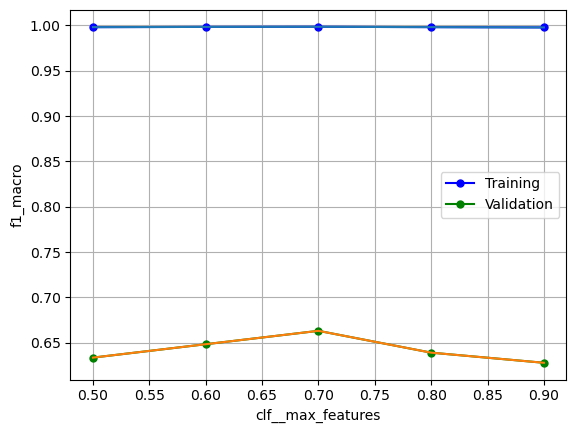

In [17]:
param_name = 'clf__max_features'
param_range = [0.5, 0.6, 0.7, 0.8, 0.9]#list(range(2, 50, 1))
 #list(range(0,1,0.05))
print(param_range)
n_jobs = 6 # max number of cores to use, -1 uses all cores - that would be 8 for me.
verbose = 2
scoring_val = make_scorer(f1_score, average='macro', zero_division=True)

train_scoreNum, test_scoreNum = validation_curve(
                                estimator=validation_pipe,
                                X=X_train, 
                                y=y_train, 
                                param_name = param_name, 
                                param_range = param_range,
                                cv = 10,
                                scoring=scoring_val,
                                verbose=verbose,
                                n_jobs=n_jobs)

train_mean = np.mean(train_scoreNum, axis=1)
test_mean = np.mean(test_scoreNum, axis=1)

# Plot the model scores (accuracy) against the paramater range
plt.plot(param_range, train_mean,
         marker='o', markersize=5,
         color='blue', label='Training')
plt.plot(param_range, test_mean,
         marker='o', markersize=5,
         color='green', label='Validation')
plt.legend()
plt.plot(param_range, train_mean)
plt.plot(param_range, test_mean)
plt.xlabel(param_name)
plt.ylabel('f1_macro')
plt.grid()
plt.show()

In [15]:
# print the mean test score along with its hyperparameter value
for i,j in zip(param_range, range(len(test_scoreNum))):
    print(i, test_scoreNum[j].mean())

# Get the best parameter value.
best_param = param_range[np.argmax(test_mean)]
print(best_param)
# 0.5 0.5884489020949648

0.25 0.6400112301722725
0.5 0.6334724595273536
0.75 0.642412523712679
0.99 0.6158828545471904
0.75


### Hyperparameter tuning with CV grid/randomised search

In [32]:
rf_paramgrid = {
    'clf__n_estimators': [30, 70],
    'clf__max_depth': [None, 7,8,9],
    'clf__min_samples_split': [4,10,40],
    'clf__max_features': [0.65, 0.7, 0.75, None],
    'clf__bootstrap': [True],
    'clf__class_weight': ['balanced_subsample']
}

gnb_paramgrid = {
    'clf__var_smoothing': [1e-3,1e-2,1e-1]
}

knn_paramgrid = [{
    'clf__n_neighbors': list(range(1,21,1)),
    'clf__metric': ['euclidean','manhattan','chebyshev','cosine','jaccard','hamming'], 
    'clf__weights': ['uniform', 'distance'],
    'clf__n_jobs':[-1],
    },
    {
    'clf__n_neighbors': list(range(2,21,1)),
    'clf__metric': ['minkowski'], 
    'clf__weights': ['uniform', 'distance'],
    'clf__n_jobs':[-1],
    'clf__p': [3,4]
    }
]

lda_paramgrid = [
    {
    'clf__solver': ['svd', 'lsqr'],
    'clf__shrinkage': [None]
    },
    {
    'clf__solver': ['lsqr','eigen'],
    'clf__shrinkage': ['auto'] + np.linspace(0,1,11).tolist()
    }
]

xgb_paramgrid = {
    'clf__n_estimators': [50, 100, 200, 250],
    'clf__learning_rate': [0.3, 0.4, 0.5],
    'clf__max_depth': [2,3,4],
    'clf__gamma': [0],
    'clf__subsample': [0.8],
    'clf__colsample_bytree': [1],
    'clf__n_jobs': [-1],
    'clf__random_state': [1]
}

In [33]:
# Initiaze the hyperparameters for each dictionary
params = xgb_paramgrid
# Select grid search cv folds
n_folds = 10
n_iter = 1000
verbose = 2
# Scorers
scoring = {
    'balanced_accuracy': make_scorer(balanced_accuracy_score),
    'precision_macro': make_scorer(precision_score, average='macro', zero_division=True), # weighted precision
    'precision_weighted': make_scorer(precision_score, average='weighted', zero_division=True), # weighted precision
    'recall_macro': make_scorer(recall_score, average='macro'), # weighted recall
    'recall_weighted': make_scorer(recall_score, average='weighted'), # weighted recall
    'f1_macro': make_scorer(f1_score, average='macro', zero_division=True), #'f1_weighted': 'f1_weighted'
    'f1_weighted': make_scorer(f1_score, average='weighted', zero_division=True),
}
#     'auc_macro': make_scorer(roc_auc_score, average='macro', multi_class='ovr'),
# }
# Compile GridSearchCV settings.
refit = 'f1_macro'
grid = RandomizedSearchCV(validation_pipe, params, scoring=scoring, refit=refit, cv=n_folds, n_iter=n_iter, verbose=verbose, n_jobs=n_jobs)


# Fit different models on training data
grid.fit(X_train, y_train)

# Place results in a dataframe.
cv_results = pd.DataFrame(grid.cv_results_)

Fitting 10 folds for each of 36 candidates, totalling 360 fits


[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learning_rate=0.3, clf__max_depth=2, clf__n_estimators=50, clf__n_jobs=-1, clf__random_state=1, clf__subsample=0.8; total time=   3.5s
[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learning_rate=0.3, clf__max_depth=2, clf__n_estimators=50, clf__n_jobs=-1, clf__random_state=1, clf__subsample=0.8; total time=   3.5s
[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learning_rate=0.3, clf__max_depth=2, clf__n_estimators=50, clf__n_jobs=-1, clf__random_state=1, clf__subsample=0.8; total time=   3.5s
[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learning_rate=0.3, clf__max_depth=2, clf__n_estimators=50, clf__n_jobs=-1, clf__random_state=1, clf__subsample=0.8; total time=   3.5s
[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learning_rate=0.3, clf__max_depth=2, clf__n_estimators=50, clf__n_jobs=-1, clf__random_state=1, clf__subsample=0.8; total time=   3.5s
[CV] END clf__colsample_bytree=1, clf__gamma=0, clf__learnin

### Use best parameters to generate a model

In [34]:
cv_results.to_csv(f'../results/cv_results_{classifierNm}_{balancing}.csv')

best_metric = 'f1_macro'
best_params = cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['params']
cv_std = cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['std_test_f1_macro']
cv_score =  cv_results.sort_values(by=f'rank_test_{best_metric}', ascending=True).iloc[0,:]['mean_test_f1_macro']
print(f'Best parameters: {best_params} \nCV score: {cv_score} \nCV std: {cv_std}')


Best parameters: {'clf__subsample': 0.8, 'clf__random_state': 1, 'clf__n_jobs': -1, 'clf__n_estimators': 50, 'clf__max_depth': 2, 'clf__learning_rate': 0.4, 'clf__gamma': 0, 'clf__colsample_bytree': 1} 
CV score: 0.6380510471039921 
CV std: 0.08116811958564697


In [35]:
# Remove the clf__ prefix from the keys
best_params = {k.replace('clf__', ''):v for k,v in best_params.items()}

test_params = {
    'clf__metric': 'nan_euclidean',
    'clf__n_jobs':-1,
    'clf__n_neighbors': 10
}
test_params = {k.replace('clf__', ''):v for k,v in test_params.items()}

random_state = 1

clf_best_params = classifier.set_params(**best_params)

# Under and oversampling strategies.
sampled2 = sampling(us_all,os_all)
undersample2 = sampled2[0]
oversample2 = sampled2[1]

# Use those to train a new model using the whole trianing set.
# Generate a pipeline to perform the column transformations sequentially.
if balancing == 'sampling':
    pipe2 = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', undersample2),
        ('os', oversample2),
        ('normalise', None),
        ('clf', clf_best_params)
    ])
elif balancing == 'weights':
    pipe2 = Pipeline([
        ('preimpnorm', normalise),
        ('impute', impute_KNN),
        ('us', None),
        ('os', None),
        ('normalise', None),
        ('clf', clf_best_params)
    ])

# If algorithm can handle missing values, do not impute.
if impute == False:
    pipe2.steps[1] = ('impute', None)

if norm == False:
    validation_pipe.steps[0] = ('preimpnorm', None)


best_model = pipe2.fit(X_train, y_train)

                   precision  recall  f1-score  support
AMCVn                   1.00    0.21      0.35       14
dwarf_nova_SU_UMa       0.79    0.90      0.84      189
dwarf_nova_U_Gem        0.62    0.60      0.61       35
dwarf_nova_Z_Cam        0.65    0.58      0.61       52
int_polar               0.00    0.00      0.00       15
nova                    0.67    0.43      0.52       14
nova_like               0.63    0.72      0.67       43
nova_like_VY_Scl        0.72    0.78      0.75       36
polar                   0.76    0.76      0.76       34
accuracy                0.73    0.73      0.73        0
macro avg               0.65    0.55      0.57      432
weighted avg            0.71    0.73      0.71      432


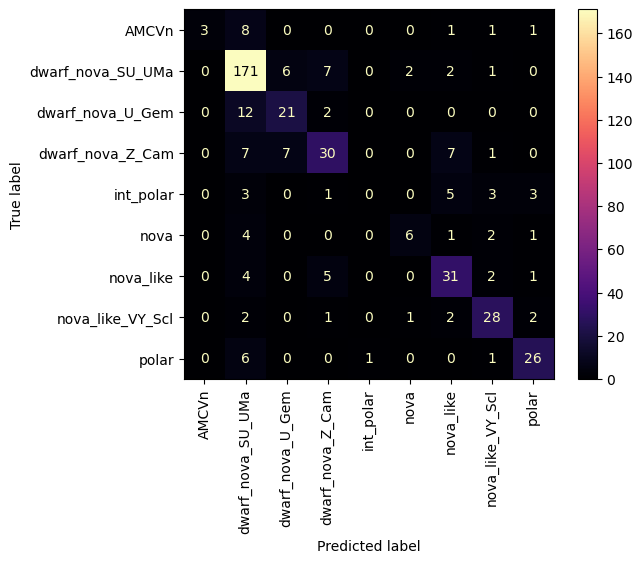

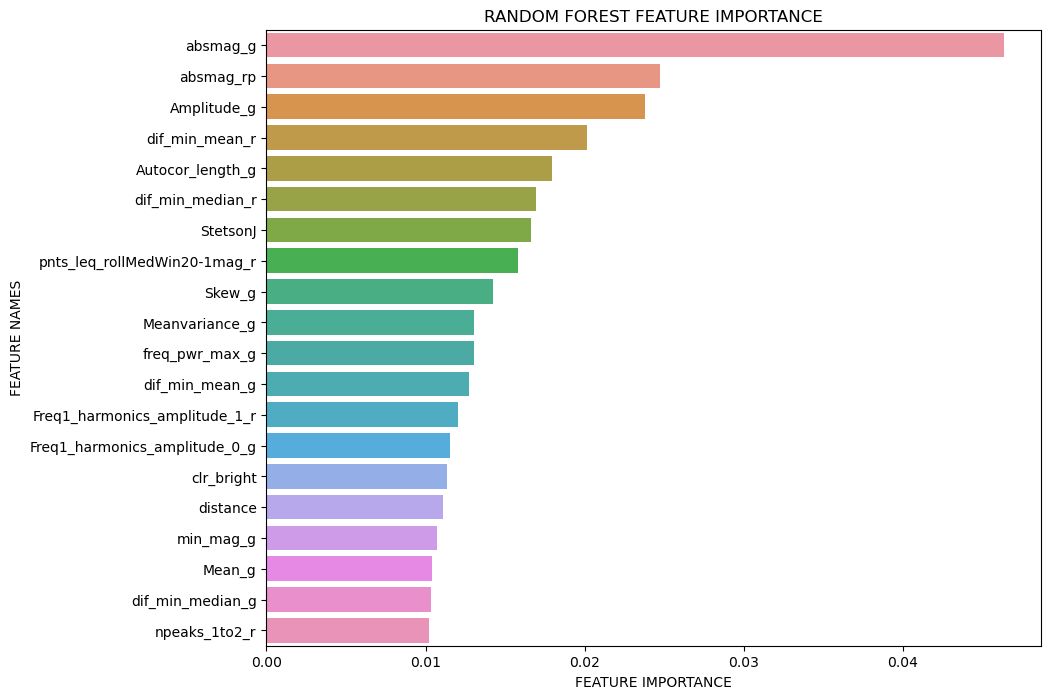

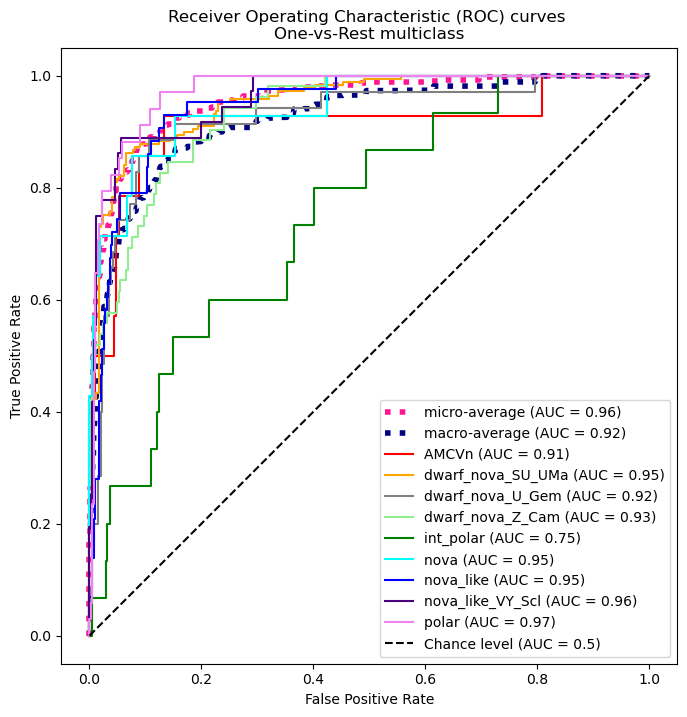

In [36]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
from matplotlib import pyplot as plt
import seaborn as sns

# # Store best parameters and best model in variables.
# best_params = grid.best_params_
# best_model = grid.best_estimator_
# print(best_params)


# Collect unique class labels in order of y_test.
class_labels = enc.inverse_transform(np.unique(y_test))


# Make predictions and gather probabilities for applying model to test set.
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)


# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred, normalize=None)
disp = ConfusionMatrixDisplay(cm, display_labels=class_labels)
disp.plot(xticks_rotation='vertical', cmap='magma')
disp.figure_.savefig(f'../results/cm_{classifierNm}_{balancing}.pdf', format='pdf', bbox_inches='tight')



# Plot roc one vs rest curves
# plot_roc(y_train, y_test, y_prob, enc, path=f'class_balance/roc_{refit}_{classifierNm}_{label_scheme}.pdf')


# Print and save the classification report
cr = classification_report(y_test, y_pred, target_names=class_labels, output_dict=True, zero_division=0)
cr_df = pd.DataFrame(cr).transpose().round({'precision':2, 'recall':2, 'f1-score':2}).astype({'support':'int64'})
cr_df.to_csv(f'../results/cr_{classifierNm}_{balancing}.csv')
print(cr_df)

try:
    feature_importance_scores = best_model.named_steps['clf'].feature_importances_
    plot_feature_importance(importance=feature_importance_scores, 
                            names=X_cols, model_type='RANDOM FOREST', top_n=20, path=f'../results/feature_importance/feature_importance_{classifierNm}_{balancing}.pdf')
except:
    pass

plot_roc(y_train, y_test, y_prob, enc, path=f'../results/roc_curve/roc_curve_{classifierNm}_{balancing}.pdf')

In [37]:
# save the model and class labels and best parameters using pickle
import pickle
pickle.dump(best_model, open(f'../results/model/model_{classifierNm}_{balancing}.pkl', 'wb'))
pickle.dump(best_params, open(f'../results/best_params/best_params_{classifierNm}_{balancing}.pkl', 'wb'))
pickle.dump(enc, open(f'../results/encoder/encoder_{classifierNm}_{balancing}.pkl', 'wb'))